# Holidays From Quandl Prices

Use the dates in a quadl bulk price download to determine market holidays.
Do not record Saturdays or Sundays.
Make sure that 11 Sep 2001 is handled properly.

## Preliminaries

import packages

In [1]:
import pandas as pd
import zipfile
from datetime import datetime
import matplotlib.pyplot as plt
from json import dump

Configuration:
- bulk price file name
- minimum number of assets required to be considered a tradeday.
- output file name

In [2]:
prc_src = '2018-02-03T02h23m27.zip'
prc_min_assets = 10
output_filename = 'holiday.json'

## Load dates

Load only the date column in the zip file and count occurances by date.

In [3]:
zf = zipfile.ZipFile(prc_src)
df = pd.read_csv(zf.open(list(zf.infolist())[0]), usecols=['date'])
tradedaycount = df.date.value_counts()

Check a few days to make sure data are reasonable.

In [4]:
for day in ['2001-09-10', '2001-09-11', '2001-09-12', '2001-09-13', '2001-09-14', '2001-09-17']:
    print('Count for {0}: {1}'.format(day, tradedaycount[day]))

Count for 2001-09-10: 1927
Count for 2001-09-11: 2
Count for 2001-09-12: 3
Count for 2001-09-13: 1
Count for 2001-09-14: 1
Count for 2001-09-17: 1927


Threshold the asset count to select the tradedays.

In [5]:
td = tradedaycount.loc[tradedaycount > prc_min_assets]

Check a few days to make sure data are reasonable.

In [6]:
for day in ['2001-09-10', '2001-09-11', '2001-09-12', '2001-09-13', '2001-09-14', '2001-09-17']:
    print('{0} {1} a tradeday'.format(day, "is" if day in td else "isn't"))
print('Tradeday date range is: [{0}, {1}]'.format(td.index.min(), td.index.max()))

2001-09-10 is a tradeday
2001-09-11 isn't a tradeday
2001-09-12 isn't a tradeday
2001-09-13 isn't a tradeday
2001-09-14 isn't a tradeday
2001-09-17 is a tradeday
Tradeday date range is: [1970-01-02, 2018-02-02]


Plot the histogram of the counts

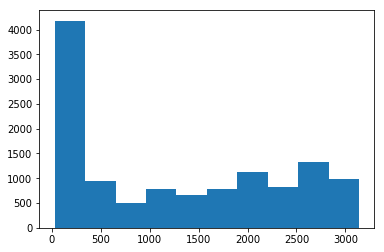

In [7]:
fig = plt.figure()
ax = fig.gca()
plt.hist(td)
plt.show()

## Calculate holidays

Holidays are determined only between the date range given in the bulk price feed.
For all the days in range, exclude the weekends and exclude the trade days.

In [8]:
def holidays(td):
    h = []
    for dt in pd.date_range(td.index.min(), td.index.max()):
        day = dt.date()
        wd = day.weekday()
        if wd > 4:
            continue
        d = datetime.strftime(day,'%Y-%m-%d')
        if d in td:
            continue;
        h.append(int(datetime.strftime(day,'%Y%m%d')))
    return h
h = holidays(td)

## Output results

The results are stored in a json file in YYYYMMDD int format.

In [9]:
with open(output_filename, "w") as outfile:
    dump({
        "holidays": h
    }, outfile, sort_keys=True, indent=4, ensure_ascii=False)